In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

## Data Preparation

As a starter, methods were created to clean all datasets, checking for missing values, outliers and duplicates.

In [81]:
def detect_missing_values(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    return missing_data.sort_values(ascending=False)

def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
            # Use IQR method
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_rows = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            outliers[column] = outlier_rows[[column]]
    
    return outliers

def detect_duplicates(df):
    duplicate_rows = df[df.duplicated()]
    return duplicate_rows

### Teams Dataset

Starting off with the teams.csv dataset, we immediately converted playoff from a string to a binary value to use later in our models. 

We also noticed that multiple columns only contained zero values, which does not give us any relevant information. Therefore, these redundant columns listed below were removed from the dataset. `divID` was full of empty strings so it was removed as well.

As numeric values were going to be needed for the models, we made sure that we had information about how each team did in the playoffs by assigning a value to each phase of the season, with 0 representing not making it to the playoffs, up to 4, meaning championship win. After applying the numerical values to the teams, the string columns `finals`, `semis` and `firstRound` were dropped.

Finally, a few more insignificant columns were dropped and duplicates, missing values and outliers were detected and dropped.

Dropped redundant rebound columns and renamed others for clarity.
Dropped 'divID' column as it contains no information.
Dropped 'seeded' column as it contains only zero values.
Dropped 'lgID', 'franchID', 'confID', 'name', and 'arena' as they are irrelevant for predictive modeling.

Missing Values
Series([], dtype: int64)

Duplicates
Empty DataFrame
Columns: [year, tmID, rank, playoff, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won, lost, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, playoff_progression_score]
Index: []

[0 rows x 46 columns]


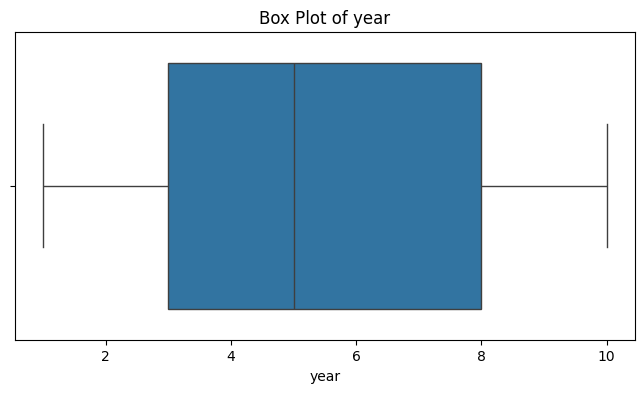

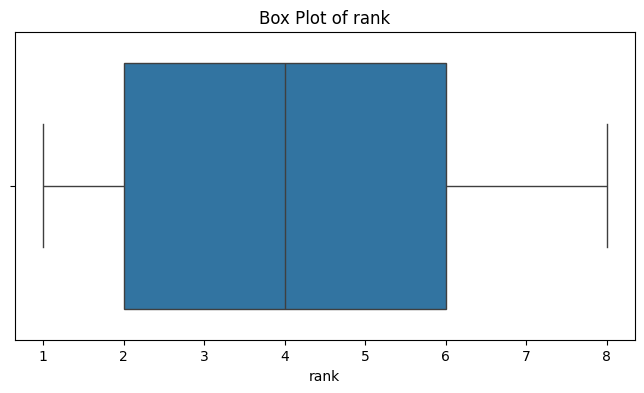

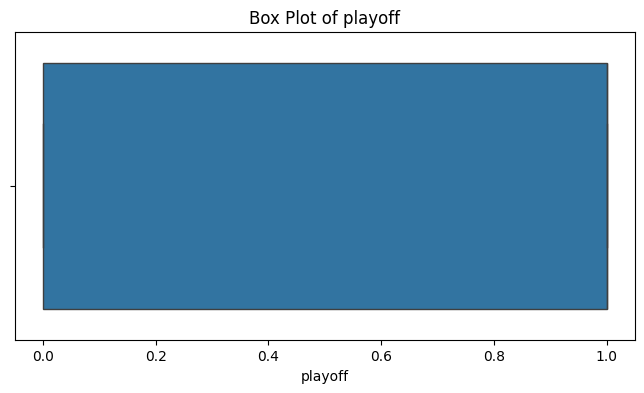

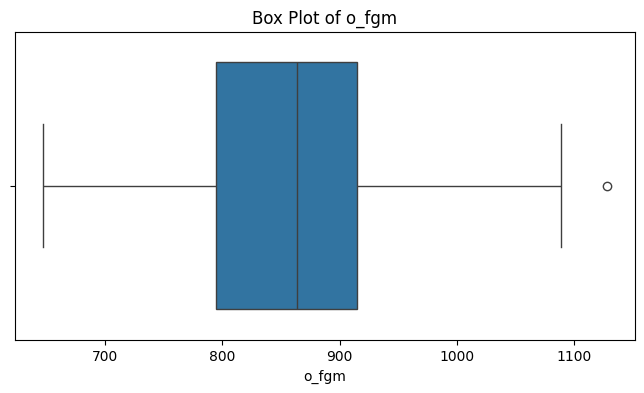

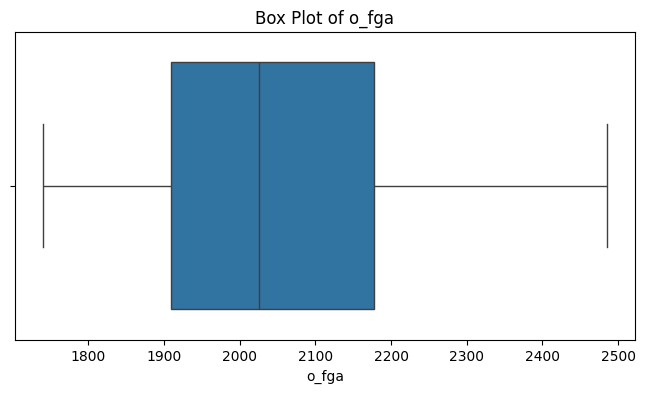

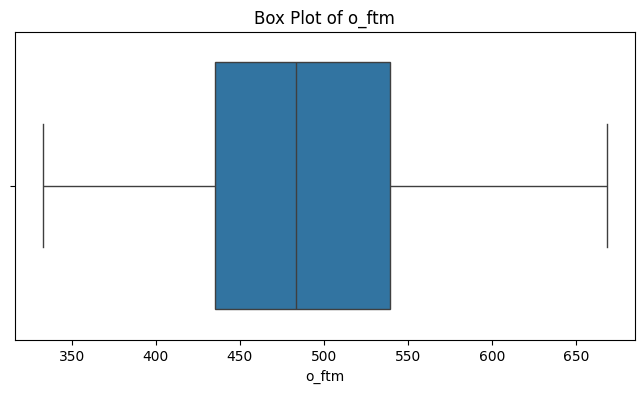

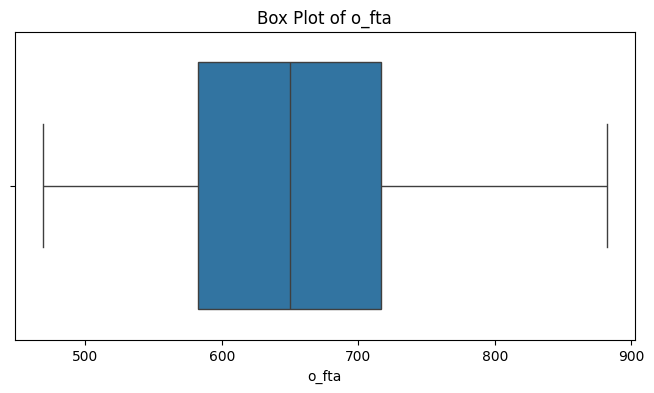

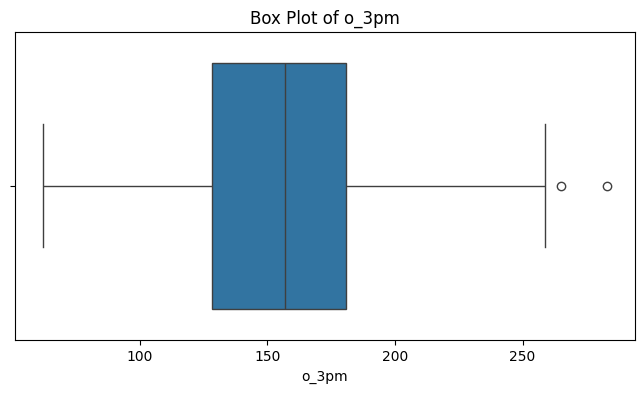

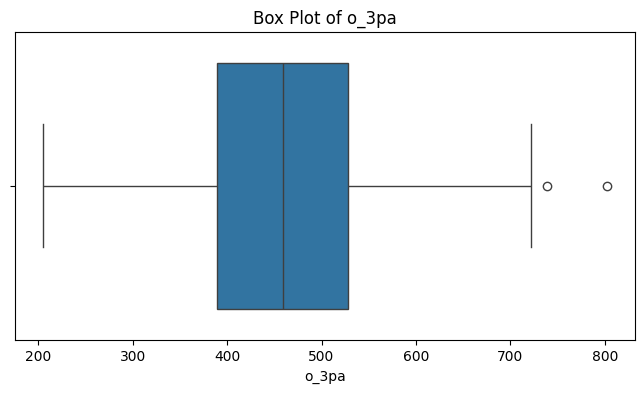

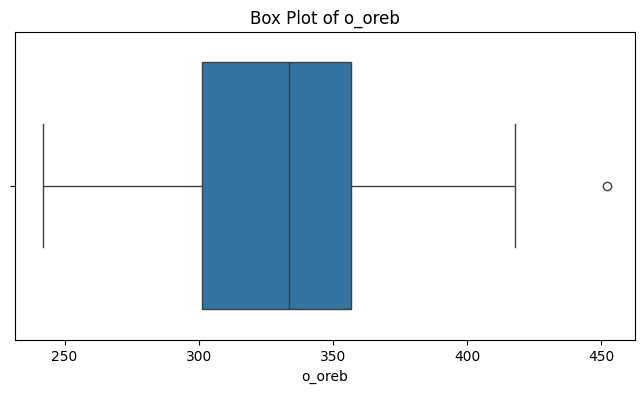

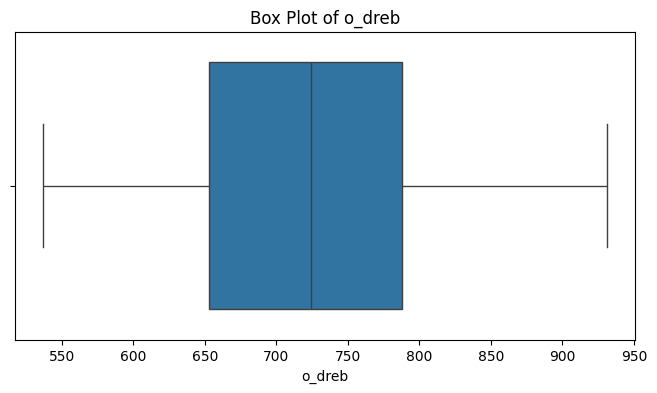

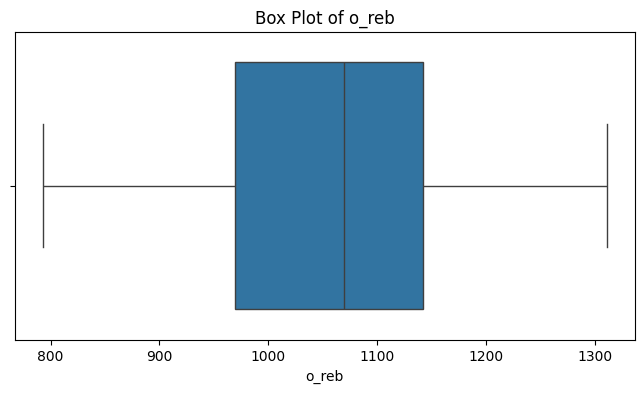

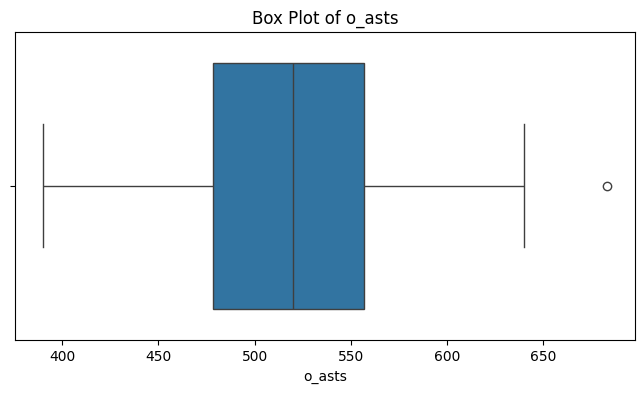

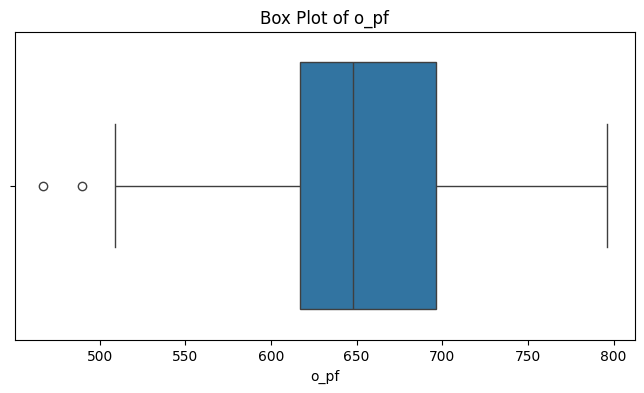

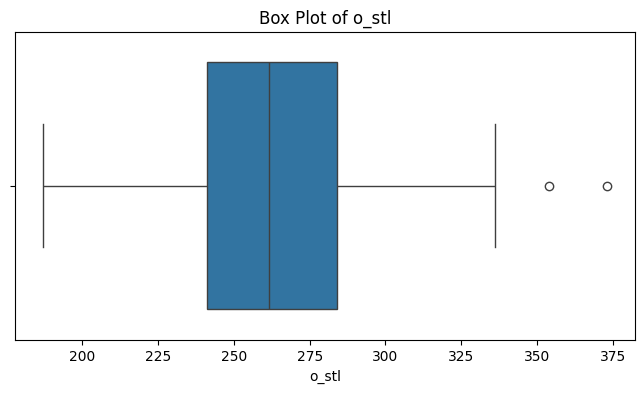

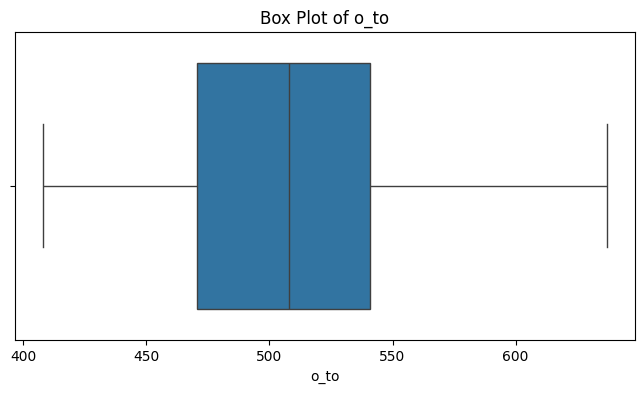

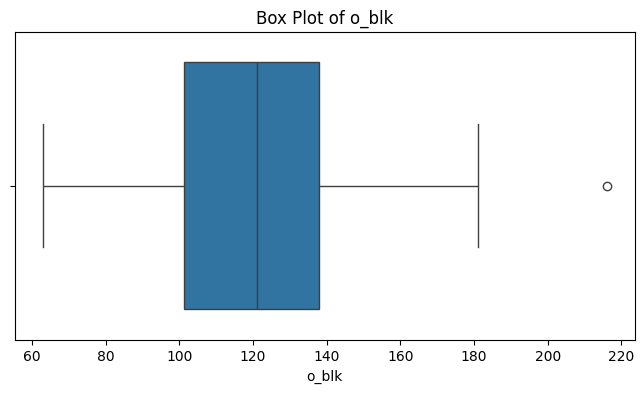

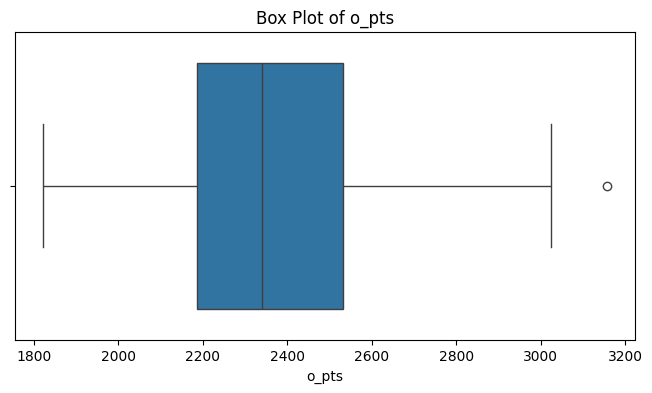

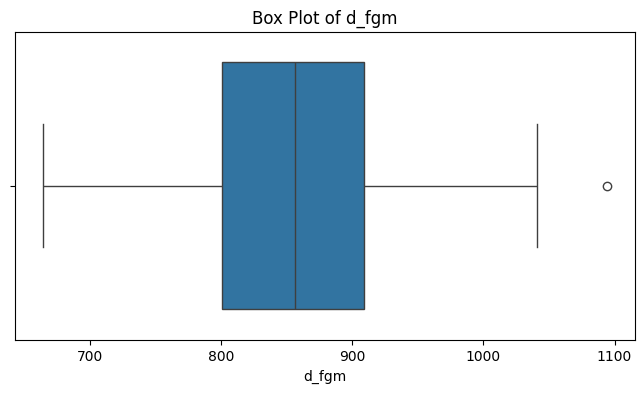

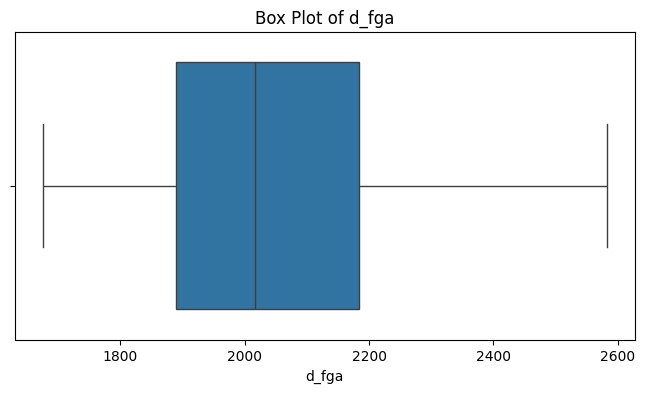

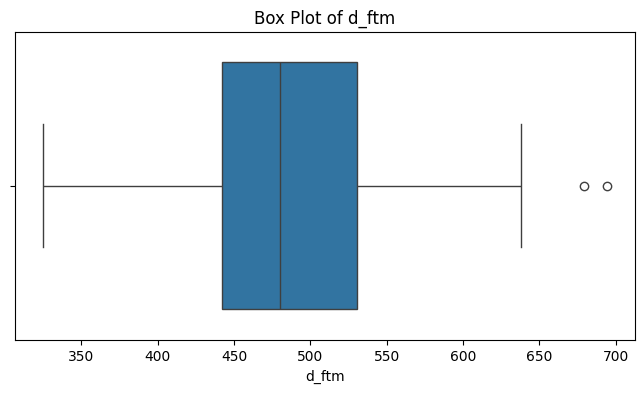

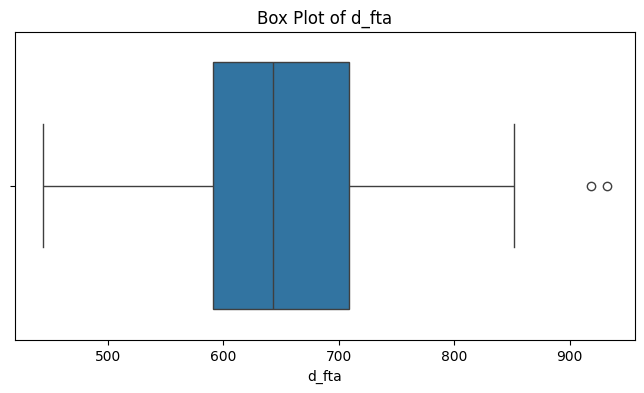

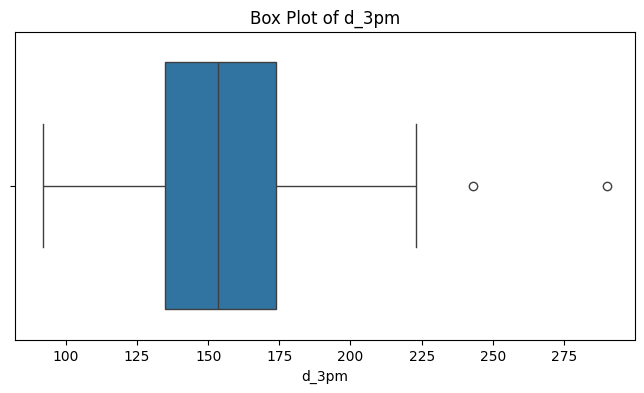

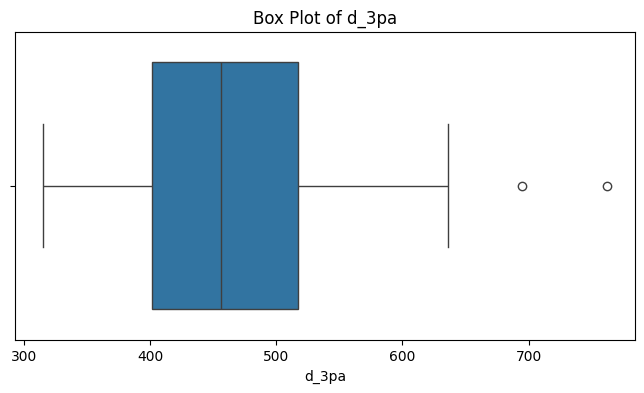

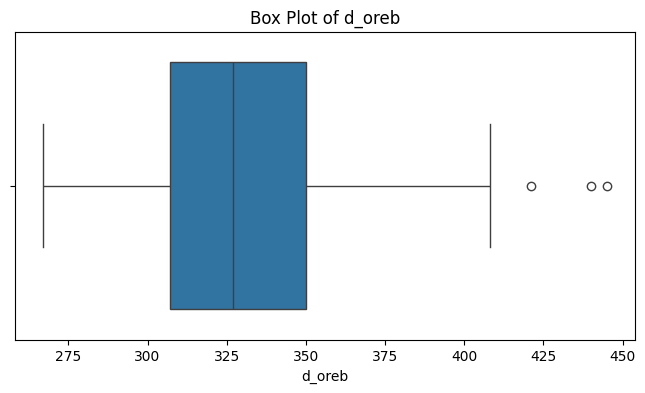

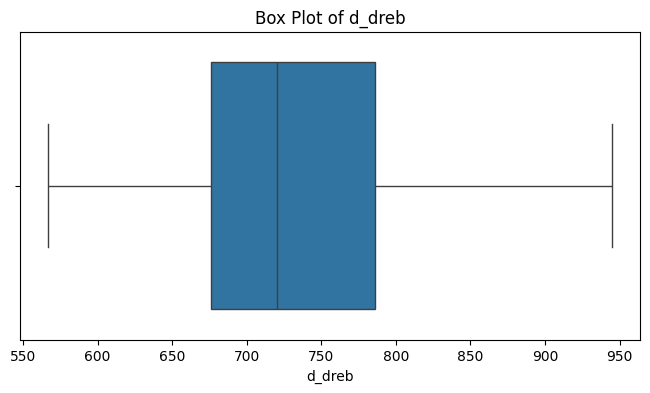

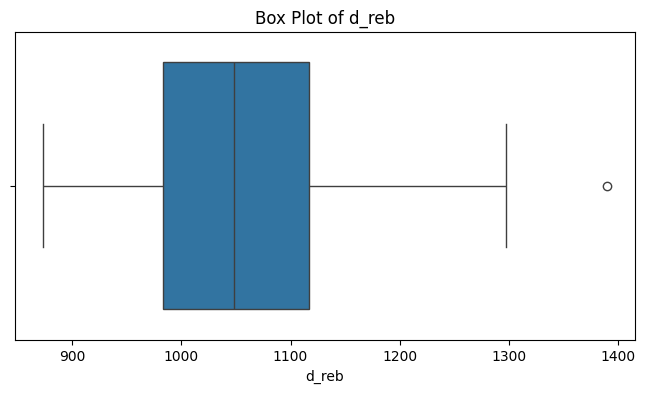

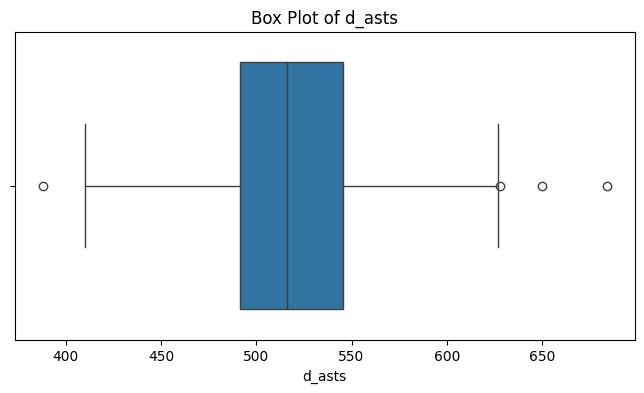

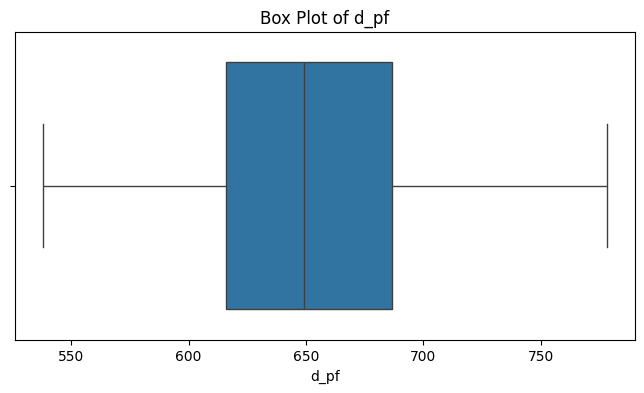

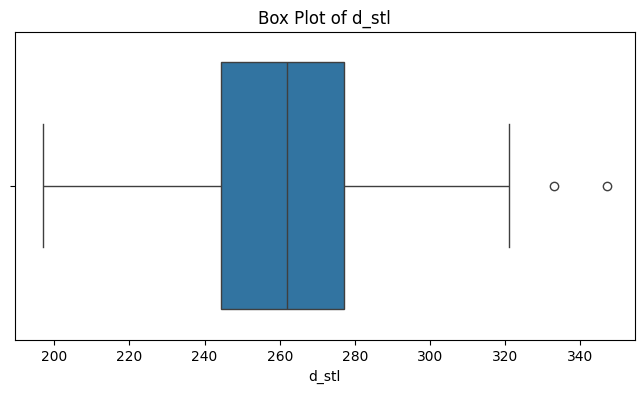

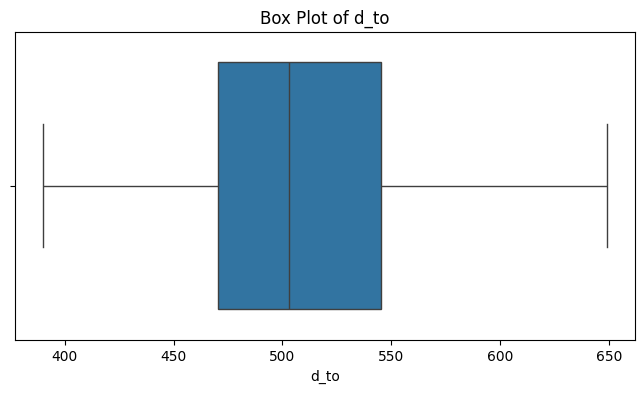

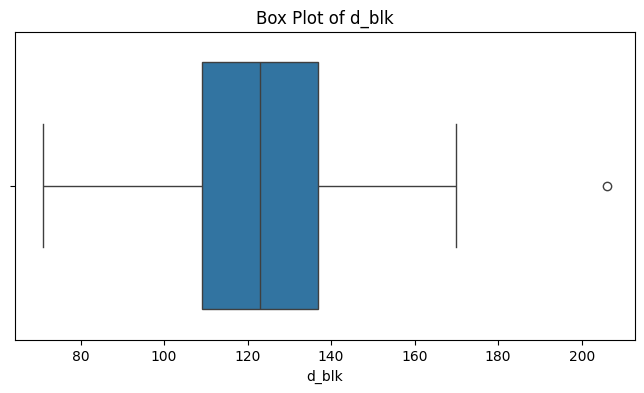

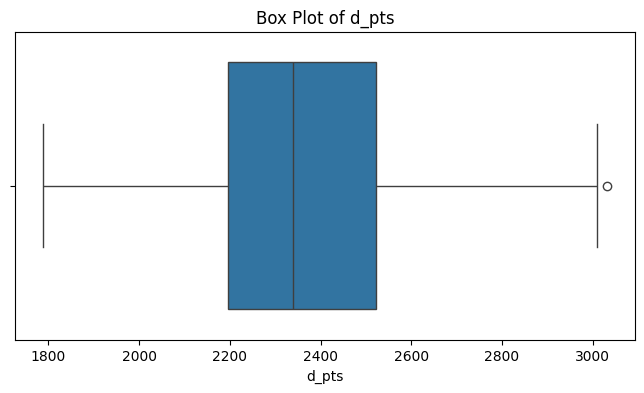

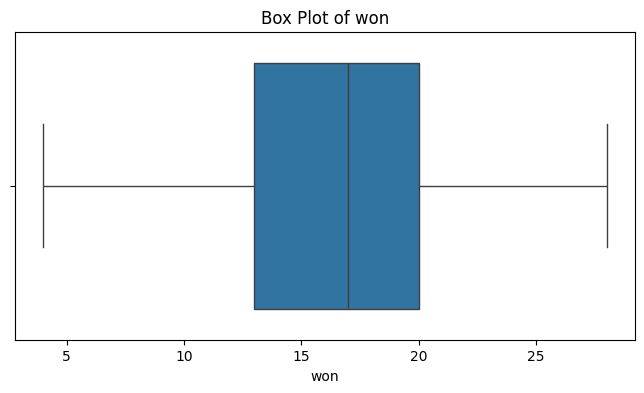

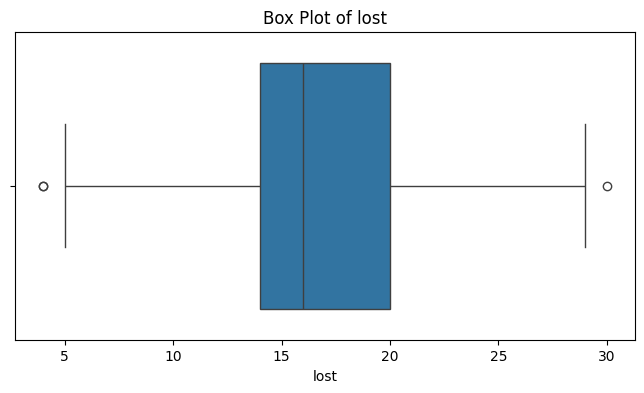

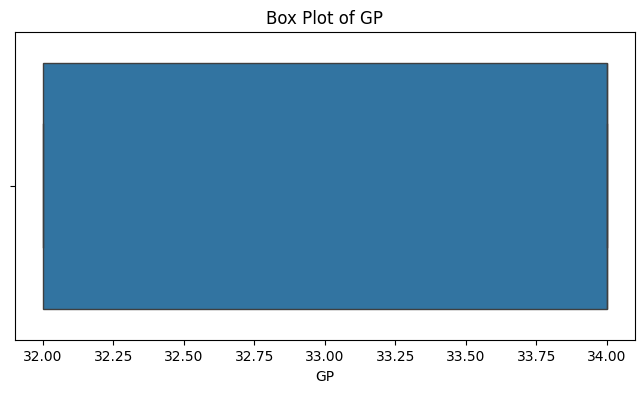

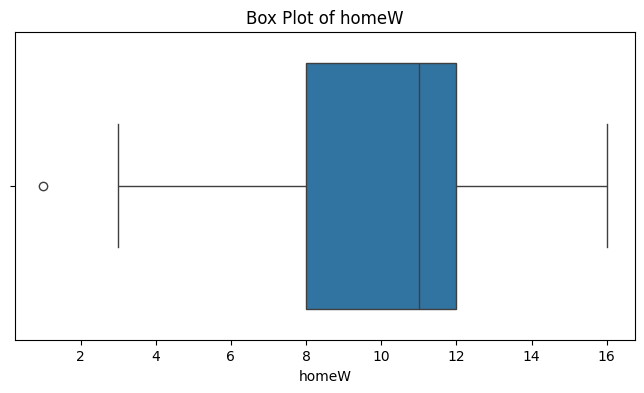

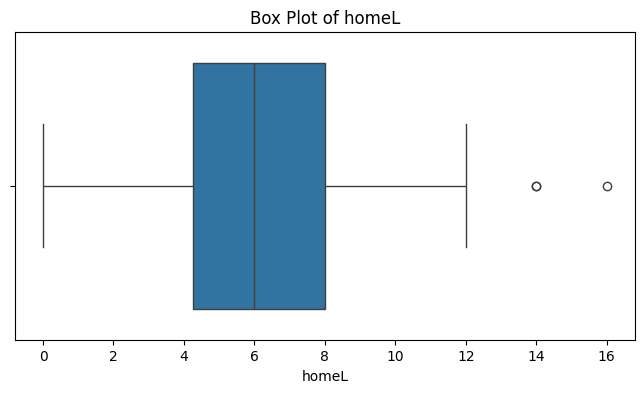

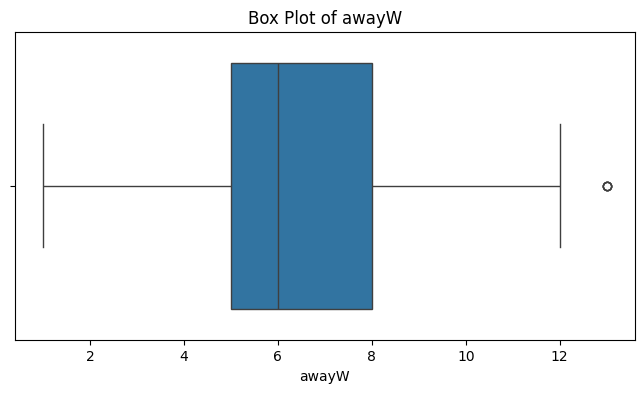

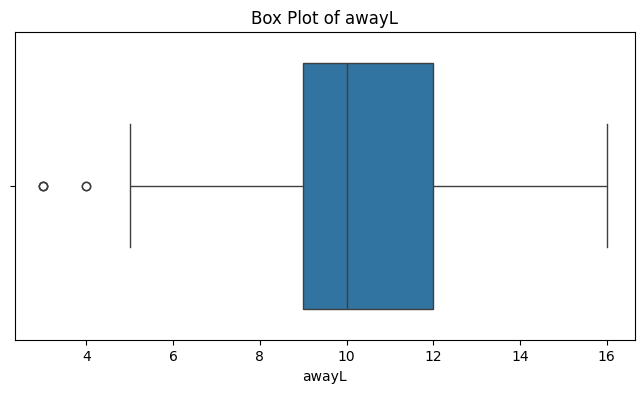

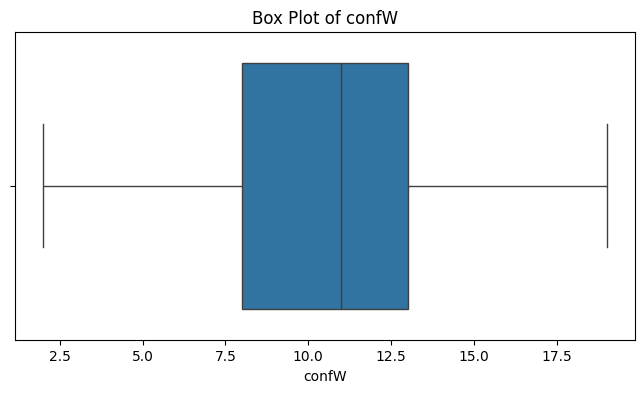

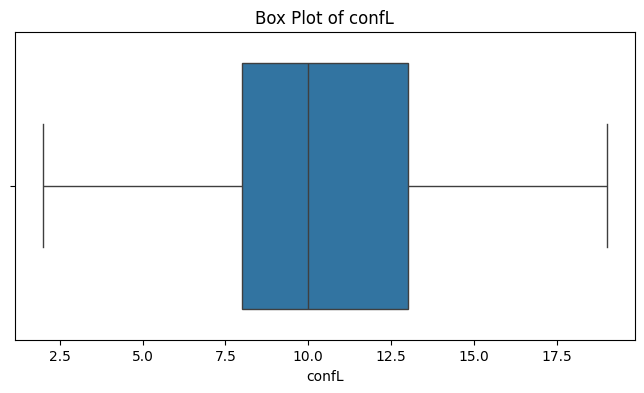

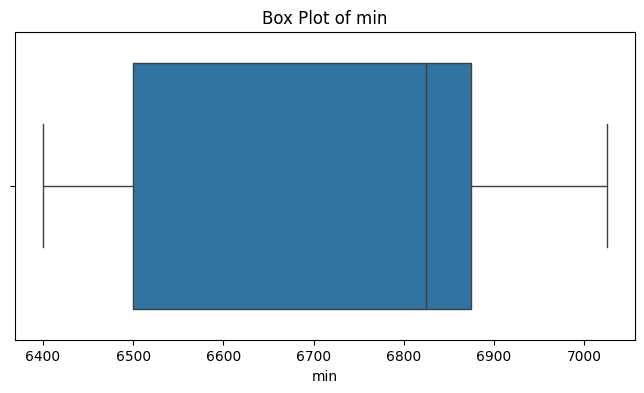

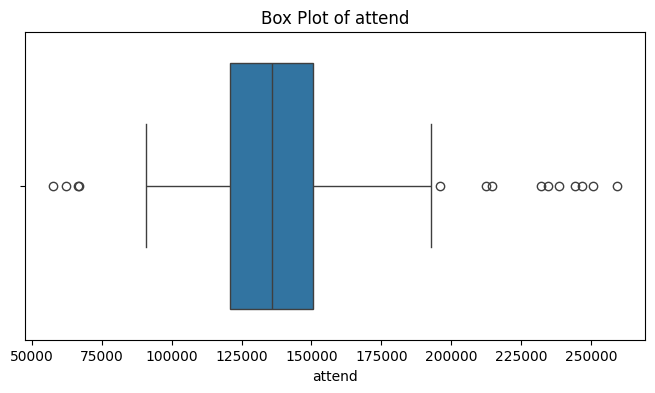

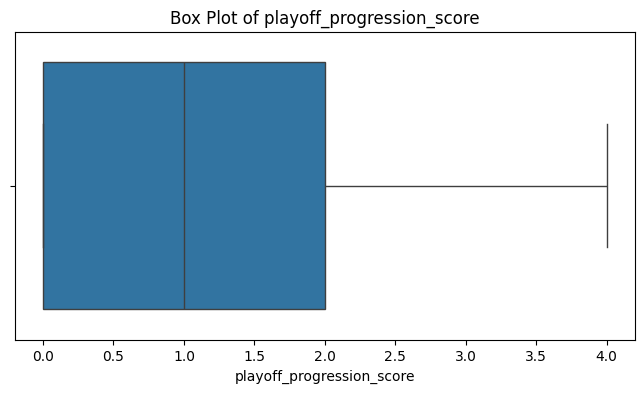

Outliers in year:
Empty DataFrame
Columns: [year]
Index: []

Outliers in rank:
Empty DataFrame
Columns: [rank]
Index: []

Outliers in playoff:
Empty DataFrame
Columns: [playoff]
Index: []

Outliers in o_fgm:
    o_fgm
98   1128

Outliers in o_fga:
Empty DataFrame
Columns: [o_fga]
Index: []

Outliers in o_ftm:
Empty DataFrame
Columns: [o_ftm]
Index: []

Outliers in o_fta:
Empty DataFrame
Columns: [o_fta]
Index: []

Outliers in o_3pm:
    o_3pm
95    265
96    283

Outliers in o_3pa:
     o_3pa
96     802
118    739

Outliers in o_oreb:
     o_oreb
109     452

Outliers in o_dreb:
Empty DataFrame
Columns: [o_dreb]
Index: []

Outliers in o_reb:
Empty DataFrame
Columns: [o_reb]
Index: []

Outliers in o_asts:
    o_asts
96     683

Outliers in o_pf:
    o_pf
36   467
37   490

Outliers in o_stl:
    o_stl
49    354
52    373

Outliers in o_to:
Empty DataFrame
Columns: [o_to]
Index: []

Outliers in o_blk:
    o_blk
61    216

Outliers in o_pts:
    o_pts
98   3156

Outliers in d_fgm:
    d_f

In [82]:
# Load the teams_post data
teams = pd.read_csv('../data/teams.csv')

# Convert 'playoff' column to binary (1 for 'Y', 0 for 'N')
teams['playoff'] = teams['playoff'].map({'Y': 1, 'N': 0})

zero_cols = ["tmORB", "tmDRB", "tmTRB", "opptmORB", "opptmDRB", "opptmTRB"]

# Since "tmORB", "tmDRB", "tmTRB", "opptmORB", "opptmDRB", and "opptmTRB" contain only zero values,
# and are redundant with "o_oreb", "o_dreb", "o_reb" for team stats, and "d_oreb", "d_dreb", "d_reb" for opponent stats,
# we drop the redundant columns.

teams = teams.drop(columns=zero_cols)
print("Dropped redundant rebound columns and renamed others for clarity.")

# Drop the 'divID' column as it contains only empty strings and does not add useful information
teams = teams.drop(columns=['divID'])
print("Dropped 'divID' column as it contains no information.")

# Drop the 'seeded' column as it contains only zero values
teams = teams.drop(columns=['seeded'])
print("Dropped 'seeded' column as it contains only zero values.")

def calculate_playoff_score(row):
    if row['finals'] == 'W':
        return 4  # Won the championship
    elif row['finals'] == 'L':
        return 3  # Lost in the finals
    elif row['semis'] == 'L':
        return 2  # Lost in the semifinals
    elif row['firstRound'] == 'L':
        return 1  # Lost in the first round
    else:
        return 0  # Did not make the playoffs

# Apply the function to each row to create the playoff_progression_score
teams['playoff_progression_score'] = teams.apply(calculate_playoff_score, axis=1)

# Drop the original 'firstRound', 'semis', and 'finals' columns as they are now redundant
teams = teams.drop(columns=['firstRound', 'semis', 'finals'])

# Drop columns that don't add predictive value
# 'lgID': Contains only "WNBA" for every row, so it provides no additional information.
# 'franchID': Redundant identifier, as 'tmID' already identifies each team uniquely.
# 'confID': Lacks value without conference-specific qualification/matchup data.
# 'name': Purely descriptive and irrelevant to playoff predictions.
# 'arena': Also descriptive and does not impact playoff qualification.
teams = teams.drop(columns=['lgID', 'franchID', 'confID', 'name', 'arena'])
print("Dropped 'lgID', 'franchID', 'confID', 'name', and 'arena' as they are irrelevant for predictive modeling.")

# DETECTION OF MISSING VALUES
missing_values = detect_missing_values(teams)
print("\nMissing Values")
print(missing_values)

# DETECTION OF DUPLICATES
duplicate_rows = detect_duplicates(teams)
print("\nDuplicates")
print(duplicate_rows)

# DETECTION OF OUTLIERS
# Select numerical columns only
numeric_columns = teams.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=teams[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

outliers = detect_outliers(teams, numeric_columns)

for col, outlier_data in outliers.items():
    print(f"Outliers in {col}:\n{outlier_data}\n")

# Store cleaned csv
teams.to_csv('../cleaned_data/teams.csv', index=False)

The same data cleaning methods used in the teams dataset were used for the rest of the datasets and stored in a new folder under the name of `cleaned_data`.

#### Teams Post Dataset

In [83]:
# Load the teams_post data
teams_post = pd.read_csv("../data/teams_post.csv")

# Drop 'lgID' column as it contains only "WNBA" for every row
teams_post = teams_post.drop(columns=['lgID'])

# Detect and drop duplicates
duplicates = teams_post[teams_post.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    teams_post = teams_post.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(teams_post.head())

# Store cleaned csv
teams_post.to_csv('../cleaned_data/teams_post.csv', index=False)

No duplicates found.


,year,tmID,W,L
0,1,HOU,6,0
1,1,ORL,1,2
2,1,CLE,3,3
3,1,WAS,0,2
4,1,NYL,4,3


#### Series Post Dataset

In [84]:
# Load the series_post data
series_post = pd.read_csv("../data/series_post.csv")

# Drop 'lgIDWinner' and 'lgIDLoser' columns as they contain only "WNBA" and add no value
series_post = series_post.drop(columns=['lgIDWinner', 'lgIDLoser'])

# Detect and drop duplicates
duplicates = series_post[series_post.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    series_post = series_post.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(series_post.head())

# Store cleaned csv
series_post.to_csv('../cleaned_data/series_post.csv', index=False)

No duplicates found.


,year,round,series,tmIDWinner,tmIDLoser,W,L
0,1,FR,A,CLE,ORL,2,1
1,1,FR,B,NYL,WAS,2,0
2,1,FR,C,LAS,PHO,2,0
3,1,FR,D,HOU,SAC,2,0
4,1,CF,E,HOU,LAS,2,0


#### Players Teams Dataset

In [85]:
# Load the players_teams data
players_teams = pd.read_csv("../data/players_teams.csv")

# Drop 'lgID' as it contains only "WNBA" and provides no unique value
players_teams = players_teams.drop(columns=['lgID'])

# Detect missing values and swap for 0's
missing_values = detect_missing_values(players_teams)
if not missing_values.empty:
    print("Missing values detected. Filling with 0's.")
    players_teams = players_teams.fillna(0)

# Detect and drop duplicates
duplicates = players_teams[players_teams.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    players_teams = players_teams.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(players_teams.head())

# Store cleaned csv
players_teams.to_csv('../cleaned_data/players_teams.csv', index=False)

Missing values detected. Filling with 0's.
No duplicates found.


,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
0,abrossv01w,2,0,MIN,26.0,23.0,846.0,343.0,43.0,131.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abrossv01w,3,0,MIN,27.0,27.0,805.0,314.0,45.0,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abrossv01w,4,0,MIN,30.0,25.0,792.0,318.0,44.0,97.0,...,1.0,8.0,8.0,22.0,6.0,8.0,8.0,7.0,3.0,0.0
3,abrossv01w,5,0,MIN,22.0,11.0,462.0,146.0,17.0,57.0,...,2.0,3.0,7.0,23.0,8.0,4.0,2.0,8.0,2.0,0.0
4,abrossv01w,6,0,MIN,31.0,31.0,777.0,304.0,29.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


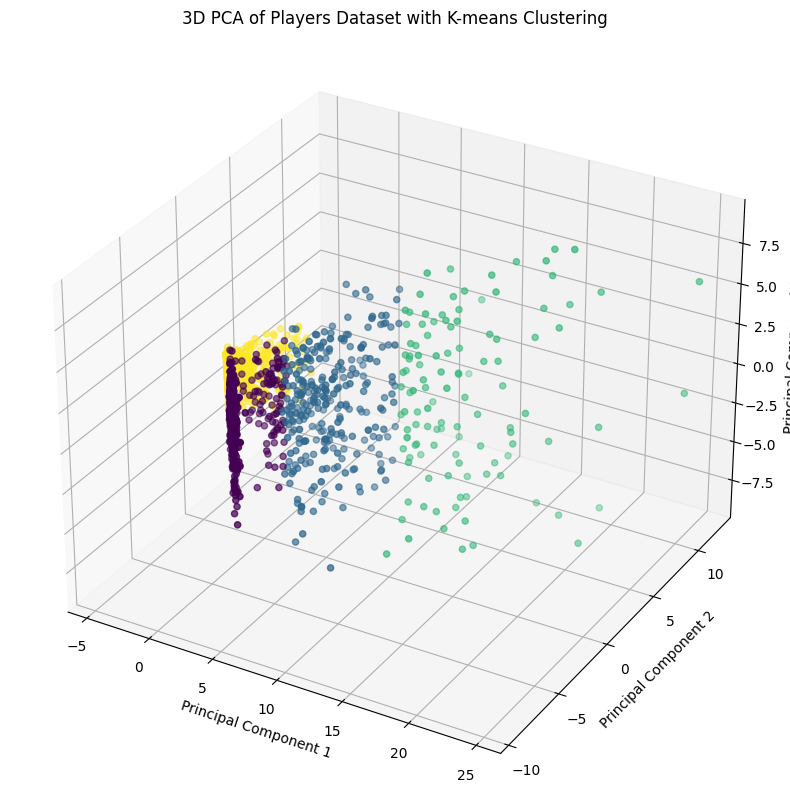

Principal Component 1 - Top 3 Features:
PostMinutes        0.190020
PostfgAttempted    0.189591
PostPoints         0.188091
Name: 0, dtype: float64
----------------------------------------
Principal Component 2 - Top 3 Features:
minutes    0.196541
PF         0.194534
PostGP     0.193056
Name: 1, dtype: float64
----------------------------------------
Principal Component 3 - Top 3 Features:
threeMade             0.398107
threeAttempted        0.397998
PostthreeAttempted    0.305898
Name: 2, dtype: float64
----------------------------------------


In [86]:
# Select the numerical columns
features = ['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 'PostthreeAttempted', 'PostthreeMade', 'PostDQ']

# Assuming players_teams is your DataFrame
x = players_teams.loc[:, features].values

# Standardize the data
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2', 'principal component 3'])

# Perform K-means clustering (adjust n_clusters based on your data)
kmeans = KMeans(n_clusters=4)  # Example: 4 clusters
kmeans.fit(principalDf)
clusters = kmeans.predict(principalDf)

# Plot the PCA results in 3D with K-means clusters
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each cluster
ax.scatter(principalDf['principal component 1'], 
           principalDf['principal component 2'], 
           principalDf['principal component 3'], 
           c=clusters, cmap='viridis')

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Players Dataset with K-means Clustering')

plt.show()

# Print the most important features for each principal component
# PCA components (loadings) show how much each feature contributes to each principal component
feature_importance = pd.DataFrame(pca.components_, columns=features)

# For each principal component, display the top 3 most important features
for i in range(3):
    top_features = feature_importance.iloc[i].abs().sort_values(ascending=False).head(3)
    print(f"Principal Component {i+1} - Top 3 Features:")
    print(top_features)
    print("-" * 40)

#### Players Dataset

For the players we eliminated the players that were not associated with any team in players_teams dataset. 

Only one player had a Death Date, so we removed the row, as this player will not have impact in predicting Season 11. We then eliminated the column because all values were the same and insignificant.

The columns firstseason and lastseason were also all zero values, so they were removed.

In [87]:
# Load the players data
players = pd.read_csv("../data/players.csv")

# Filter out rows in players that do not have corresponding playerIDs in players_teams
valid_player_ids = players_teams['playerID'].unique()
players = players[players['bioID'].isin(valid_player_ids)]

# Show that all values in firstseason and lastseason are '0'
firstseason_all_zero = (players['firstseason'] == 0).all()
lastseason_all_zero = (players['lastseason'] == 0).all()

print("All values in 'firstseason' are 0:", firstseason_all_zero)
print("All values in 'lastseason' are 0:", lastseason_all_zero)

# Show the only valida player with a registered Death Date
non_zero_death_dates = players[players['deathDate'] != "0000-00-00"]
display(non_zero_death_dates.head())

# Even though there is 1 registered Death Date, it really doesn't add anything. Birth Date is kept, for potential aging information.
players = players.drop(columns=['firstseason', 'lastseason', 'deathDate'])
print("Dropped 'firstseason', 'lastseason', and 'deathDate' columns as they contain only irrelevant values.")

# Detect and drop duplicates
duplicates = players[players.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    players = players.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(players.head())

# Store cleaned csv
players.to_csv('../cleaned_data/players.csv', index=False)

All values in 'firstseason' are 0: True
All values in 'lastseason' are 0: True


,bioID,pos,firstseason,lastseason,height,weight,college,collegeOther,birthDate,deathDate
225,dydekma01w,C,0,0,9.0,223,NaN,NaN,1974-04-28,2011-05-27


Dropped 'firstseason', 'lastseason', and 'deathDate' columns as they contain only irrelevant values.
No duplicates found.


,bioID,pos,height,weight,college,collegeOther,birthDate
1,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
2,adairje01w,C,76.0,197,George Washington,NaN,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,Jefferson College (JC),1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,NaN,1981-05-24
8,aguilel01w,G,67.0,165,George Washington,NaN,1976-10-15


#### Coaches Dataset

In [88]:
# Load the coaches data
coaches = pd.read_csv("../data/coaches.csv")

# Drop 'lgID' as it is only "WNBA" and provides no unique value
coaches = coaches.drop(columns=['lgID'])

# Detect and drop duplicates
duplicates = coaches[coaches.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    coaches = coaches.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(coaches.head())

coaches.to_csv('../cleaned_data/coaches.csv', index=False)

No duplicates found.


,coachID,year,tmID,stint,won,lost,post_wins,post_losses
0,adamsmi01w,5,WAS,0,17.0,17.0,1.0,2.0
1,adubari99w,1,NYL,0,20.0,12.0,4.0,3.0
2,adubari99w,2,NYL,0,21.0,11.0,3.0,3.0
3,adubari99w,3,NYL,0,18.0,14.0,4.0,4.0
4,adubari99w,4,NYL,0,16.0,18.0,0.0,0.0


#### Awards dataset

For the awards dateset, we felt the names could be shorter and standardized. The awards in the dataframe were separated into two separate datasets, one for coaches and the other for players, that we will later include in the respective datasets.

In [89]:
# Load the awards_players data
awards_players = pd.read_csv("../data/awards_players.csv")

# Drop 'lgID' column as it provides no unique value
awards_players = awards_players.drop(columns=['lgID'])

# Separate dataframes for player awards and coach awards
player_awards = awards_players[~awards_players['award'].str.contains("Coach")].copy()
coach_awards = awards_players[awards_players['award'].str.contains("Coach")].copy()

# Standardize award names
award_name_mapping = {
    "Kim Perrot Sportsmanship": "Kim Perrot Sportsmanship Award",
    "Kim Perrot Sportsmanship Award": "Kim Perrot Sportsmanship Award",
    "All-Star Game Most Valuable Player": "All-Star Game MVP",
    "Most Valuable Player": "MVP",
    "WNBA Finals Most Valuable Player": "Finals MVP",
    "Sixth Woman of the Year": "6th Woman of the Year",
    "WNBA All-Decade Team": "All-Decade Team",
    "WNBA All Decade Team Honorable Mention": "All-Decade Team Honorable Mention"
}

player_awards.loc[:, 'award'] = player_awards['award'].map(award_name_mapping).fillna(player_awards['award'])
coach_awards.loc[:, 'award'] = coach_awards['award'].map(award_name_mapping).fillna(coach_awards['award'])

# Detect and drop duplicates
duplicates_player = player_awards[player_awards.duplicated()]
if not duplicates_player.empty:
    print("Duplicates detected in player awards. Removing duplicate rows.")
    player_awards = player_awards.drop_duplicates()
else:
    print("No duplicates found in player awards.")

duplicates_coach = coach_awards[coach_awards.duplicated()]
if not duplicates_coach.empty:
    print("Duplicates detected in coach awards. Removing duplicate rows.")
    coach_awards = coach_awards.drop_duplicates()
else:
    print("No duplicates found in coach awards.")

# Swap 'playerID' for 'coachID' in coach awards
coach_awards = coach_awards.rename(columns={'playerID': 'coachID'})

# Display samples of both dataframes to verify transformations
display(player_awards.head())
display(coach_awards.head())

# Store cleaned csvs
player_awards.to_csv('../cleaned_data/player_awards.csv', index=False)
coach_awards.to_csv('../cleaned_data/coach_awards.csv', index=False)

No duplicates found in player awards.
No duplicates found in coach awards.


,playerID,award,year
0,thompti01w,All-Star Game MVP,1
1,leslili01w,All-Star Game MVP,2
2,leslili01w,All-Star Game MVP,3
3,teaslni01w,All-Star Game MVP,4
4,swoopsh01w,All-Star Game MVP,6


,coachID,award,year
8,coopemi01w,Coach of the Year,1
9,hugheda99w,Coach of the Year,2
10,stanlma99w,Coach of the Year,3
11,laimbbi01w,Coach of the Year,4
12,mcconsu01w,Coach of the Year,5
